In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from wordcloud import WordCloud

In [32]:
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
#for model-building
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
val_df=pd.read_csv("val.csv")
val_df.dropna(inplace = True)
#Adding headers to the data columns
val_df.columns = ['text','target']
val_df.head()

,text,target
0,"wong kar-wei's "" fallen angels "" is , on a pur...",1
1,there is nothing like american history x in th...,1
2,"an unhappy italian housewife , a lonely waiter...",1
3,"when people are talking about good old times ,...",1
4,the rocky horror picture show 'special edition...,1


In [4]:
train_df=pd.read_csv("train.csv")
train_df.dropna(inplace = True)

#Adding headers to the data columns
train_df.columns = ['text','target']
train_df.head()


,text,target
0,note : some may consider portions of the follo...,1
1,every once in a while you see a film that is s...,1
2,"when i was growing up in 1970s , boys in my sc...",1
3,"the muppet movie is the first , and the best m...",1
4,do film critics have morals ? are there any u...,1


In [5]:
test_df=pd.read_csv("test.csv")
test_df.dropna(inplace = True)
#Adding headers to the data columns
test_df.columns = ['text','target']
test_df.head()

,text,target
0,"i know it already opened in december , but i f...",1
1,"what's shocking about "" carlito's way "" is how...",1
2,uncompromising french director robert bresson'...,1
3,"aggressive , bleak , and unrelenting film abou...",1
4,touchstone pictures and spyglass entertainment...,1


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1399 non-null   object
 1   target  1399 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 22.0+ KB


In [8]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
target,1399.0,0.499643,0.500179,0.0,0.0,0.0,1.0,1.0


In [9]:
train_df.isna().sum()  #Missing values

text      0
target    0
dtype: int64

In [10]:
#checking for number of unique values
train_df.nunique()

text      1399
target       2
dtype: int64

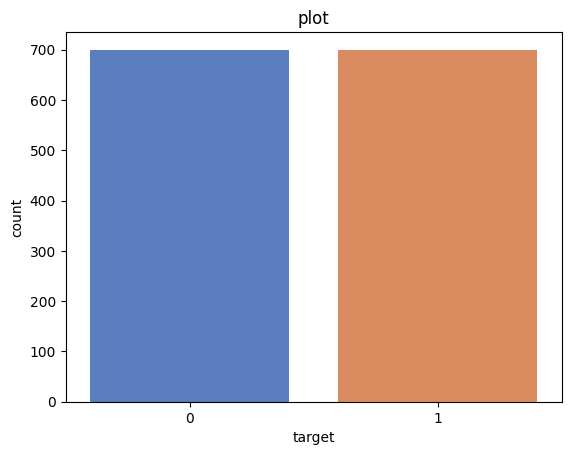

In [15]:
sns.countplot(x = 'target',  data = train_df, palette = 'muted')
plt.title('plot')
plt.show()

In [16]:
# WORD-COUNT
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
print(train_df[train_df['target']==1]['word_count'].mean()) #Disaster tweets
print(train_df[train_df['target']==0]['word_count'].mean()) #Non-Disaster tweets

788.2904148783977
714.1228571428571


In [17]:
#CHARACTER-COUNT
train_df['char_count'] = train_df['text'].apply(lambda x: len(str(x)))
print(train_df[train_df['target']==1]['char_count'].mean()) #Disaster tweets
print(train_df[train_df['target']==0]['char_count'].mean()) #Non-Disaster tweets

4132.080114449213
3708.9185714285713


In [18]:
#UNIQUE WORD-COUNT
train_df['unique_word_count'] = train_df['text'].apply(lambda x: len(set(str(x).split())))
print(train_df[train_df['target']==1]['unique_word_count'].mean()) #Disaster tweets
print(train_df[train_df['target']==0]['unique_word_count'].mean()) #Non-Disaster tweets

358.6852646638054
336.66857142857145


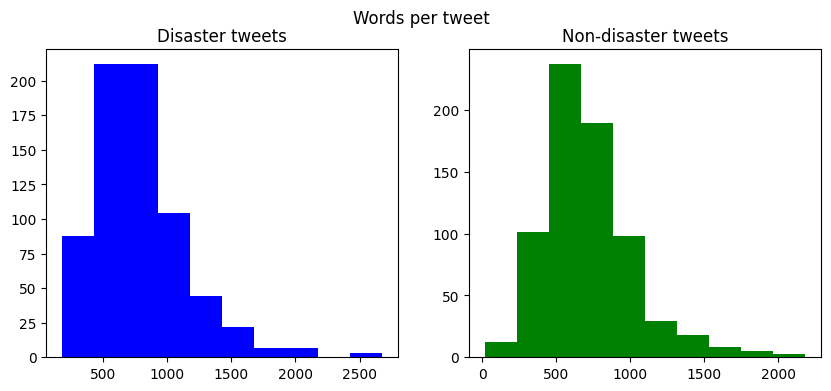

In [19]:
#Plotting word-count per tweet
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
train_words = train_df[train_df['target']==1]['word_count']

ax1.hist(train_words,color='b')
ax1.set_title('Disaster tweets')

train_words= train_df[train_df['target']==0]['word_count']

ax2.hist(train_words,color='green')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Words per tweet')
plt.show()

Text cleaning

In [20]:
#convert to lowercase and remove punctuations and characters and then strip
def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text

In [21]:
#STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

In [22]:
#Initialize the stemmer
snow = SnowballStemmer('english')
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)

In [23]:
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
# Full list is available here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [24]:
#Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [25]:
#FINAL PREPROCESSING
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

train_df['clean_text'] = train_df['text'].apply(lambda x: finalpreprocess(x))

train_df.head()

,text,target,word_count,char_count,unique_word_count,clean_text
0,note : some may consider portions of the follo...,1,1079,6171,547,note may consider portion follow text spoiler ...
1,every once in a while you see a film that is s...,1,851,4278,374,every see film effective deliver good easy for...
2,"when i was growing up in 1970s , boys in my sc...",1,840,4524,393,grow boys school use divide two group base act...
3,"the muppet movie is the first , and the best m...",1,462,2379,211,muppet movie first best movie among ever grow ...
4,do film critics have morals ? are there any u...,1,1578,8128,599,film critic moral unwritten law ethical movie ...


In [26]:
train_df=train_df.drop(columns=['word_count','char_count','unique_word_count'])
train_df.head()

,text,target,clean_text
0,note : some may consider portions of the follo...,1,note may consider portion follow text spoiler ...
1,every once in a while you see a film that is s...,1,every see film effective deliver good easy for...
2,"when i was growing up in 1970s , boys in my sc...",1,grow boys school use divide two group base act...
3,"the muppet movie is the first , and the best m...",1,muppet movie first best movie among ever grow ...
4,do film critics have morals ? are there any u...,1,film critic moral unwritten law ethical movie ...


In [ ]:
1. Choose and implement a text representation technique (such as bag of words, word embeddings etc.). Justify your choice.

In [27]:
vect = CountVectorizer()
vect.fit(train_df['clean_text'])

CountVectorizer()

In [34]:
bag_of_words = vect.transform(train_df['clean_text'])
print(bag_of_words)
print('{} Number of texts has {} words'.format(bag_of_words.shape[0], bag_of_words.shape[1]))

  (0, 40)	1
  (0, 129)	1
  (0, 158)	1
  (0, 267)	1
  (0, 271)	1
  (0, 279)	1
  (0, 302)	1
  (0, 369)	1
  (0, 432)	1
  (0, 447)	1
  (0, 490)	1
  (0, 622)	1
  (0, 650)	1
  (0, 652)	1
  (0, 674)	2
  (0, 711)	1
  (0, 743)	1
  (0, 756)	1
  (0, 800)	1
  (0, 987)	2
  (0, 998)	1
  (0, 1033)	1
  (0, 1072)	2
  (0, 1158)	1
  (0, 1203)	3
  :	:
  (1398, 24420)	3
  (1398, 24697)	4
  (1398, 24737)	1
  (1398, 24781)	2
  (1398, 24868)	3
  (1398, 25021)	1
  (1398, 25258)	1
  (1398, 25410)	1
  (1398, 25415)	1
  (1398, 25923)	1
  (1398, 26285)	2
  (1398, 26415)	1
  (1398, 26728)	4
  (1398, 26838)	1
  (1398, 26881)	1
  (1398, 26939)	1
  (1398, 26949)	6
  (1398, 26972)	1
  (1398, 27000)	1
  (1398, 27067)	1
  (1398, 27319)	3
  (1398, 27383)	1
  (1398, 27505)	1
  (1398, 27513)	3
  (1398, 27640)	1
1399 Number of texts has 27844 words


In [37]:
# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer( min_df=5, encoding='latin-1', ngram_range=(1, 2), stop_words='english')
# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(train_df["clean_text"])
# Print the first 10 features of the count_vectorizer
print(count_vectorizer.get_feature_names_out()[:20])


['aaron' 'abandon' 'abby' 'ability' 'ability make' 'able' 'able create'
 'able make' 'ably' 'aboard' 'abortion' 'abound' 'abraham' 'abrasive'
 'abrupt' 'abruptly' 'absence' 'absent' 'absolute' 'absolutely']


In [ ]:
Using the text representation from (1), build a machine learning model for text classification
(e.g. decision tree, neural network etc.). Justify your choice

In [39]:
# Transform the training data using only the 'text' column values: count_train 
train_label = train_df["target"]

In [40]:
# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
cnb_classifier = MultinomialNB()

# Fit the classifier to the training data
cnb_classifier.fit(count_train, train_label)





MultinomialNB()

In [ ]:
# Calculate the accuracy score: score
score = metrics.accuracy_score(test_label, c_pred)
print(score)
# Create the predicted tags: pred
c_pred = cnb_classifier.predict(count_test)

